# About

Started in 2001, __[Resident Advisor](http://www.residentadvisor.com)__ (RA) has become the web's largest resource for information about underground electronic music around the world. The site maintains a huge database of music and tech reviews, artists, labels, news, podcasts, and events.

Gathered using a web-scraping script, the dataset below is of the site's entire collection of music reviews from the start of the site through the end of 2017. It contains the following fields:

 - Release Type (album or single)
 - Artist
 - Release Title
 - Label
 - Release Month
 - Release Year
 - Style (genres of release listed by RA)
 - Rating (score out of 5 given by RA)
 - Date of Review
 - Review Author
 - Body of Review
 - Release Tracklist
 
 
Below, let's take a look at some of the stories we can tell with this review data.

## Data Import and Cleaning

First, necessary imports.

In [1]:
#imports

%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In the 16-year history of reviews, occasionally, there are some typos. Nowhere does this cause more problems for analysis than one particualrly common typo, a catalog ID entered for the release date. In this case, in order to have clean data, we can detect any releases with release_year or release_month values that are not years or months, respectively, and impute the correct values with the review date, which comes in a dependable timestamp. While it is possible for a review to have been reviewed independently of it's release date, most reviews are completed within a short timeframe after the release being put on sale. Therefore it's a solid guess for a missing value.

#### Cleaning Functions

In [2]:
#Function Definitions

def CleanYears(row):
    
    #This function checks the row for a year that isn't a year, 
    #if it's not a year, it assigns the release year to the year the review was published, the best guess we have.
    
    years = ['2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017']
    
    if row['release_year'] in years:
        return row['release_year']
    else:
        return str(row['review_published'].year)
    
    
def CleanMonths(row):
    
    #This function checks the row for a month that isn't a month, 
    #if it's not a month, it assigns the release month to the month the review was published, the best guess we have.
    
    months = ["January","February","March","April","May","June","July","August","September","October","November","December"]
    
    look_up = {'01': 'January', '02': 'February', '03': 'March', '04': 'April', '05': 'May',
            '06': 'June', '07': 'July', '08': 'August', '09': 'September', '10': 'October', '11': 'November', '12': 'December'}

    if row['release_month'] in months:
        return row['release_month']
    else:
        return look_up[str(df.review_published.iloc[0].month)]
    
    
def StripWhitespace(artist):
    return artist.rstrip()

    

#### Imports and Cleaning

In [3]:
#read csv file
df = pd.read_csv("/Users/marcschroeder/Documents/personal/programming projects/RAReviewsData/RA.csv",delimiter=';',header=0,index_col="ra_review_id")

#convert published date to datetime
df.review_published = pd.to_datetime(df.review_published)

#apply cleaning functions defined above
df.release_year = df.apply(CleanYears,axis=1)
df.release_month = df.apply(CleanMonths,axis=1)
fixed_artist = df.artist.apply(StripWhitespace)
df.artist = fixed_artist

Now that we've loaded our dataset, let's answer a few simple questions.

## Do albums get rated higher than singles?

In [4]:
print df.groupby("release_type").rating.mean()

release_type
album     3.723210
single    3.695682
Name: rating, dtype: float64


 
In general, only by a little bit. How about year-over-year? 
 

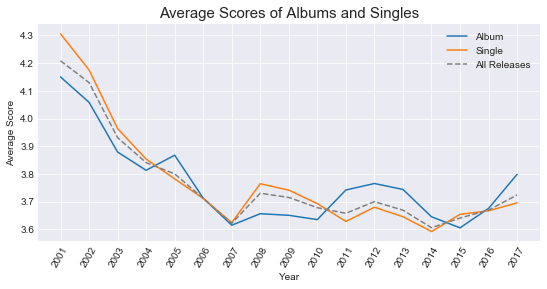

In [27]:
release_type_score_by_year = df.groupby(["release_year","release_type"]).rating.mean().unstack(level=-1)
yearly_average_score = df.groupby("release_year").rating.mean()

plt.figure(figsize=(9,4))
_ = plt.plot(release_type_score_by_year.album)
_ = plt.plot(release_type_score_by_year.single)
_ = plt.plot(yearly_average_score,linestyle="--",c='grey')

plt.xticks(rotation=60)
plt.xlabel("Year")
plt.ylabel("Average Score")
plt.legend(("Album","Single","All Releases"))
plt.title("Average Scores of Albums and Singles",size=15)
plt.show()

Not really a clear trend of dominance here. The formats will have trends, but there's not enough evidence to say that the site clearly prefers an EP to an LP or vice-versa.

## Have albums always been an important part of RA reviews?

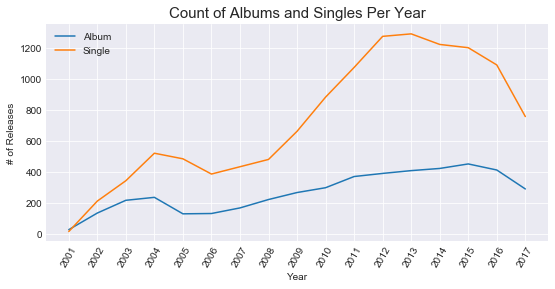

In [29]:
release_type_count_by_year = df.groupby(["release_year","release_type"]).artist.count().unstack(level=-1)

plt.figure(figsize=(9,4))
_ = plt.plot(release_type_count_by_year.album)
_ = plt.plot(release_type_count_by_year.single)


plt.xticks(rotation=60)
plt.xlabel("Year")
plt.ylabel("# of Releases")
plt.legend(("Album","Single"))
plt.title("Count of Albums and Singles Per Year", size=15)
plt.show()

Yes, album reviews have always been a significant part of the site's reviews, but starting in 2008, RA appears to have made a clear effort to review more singles

## Are there prolific artists that have a particularly high average score?

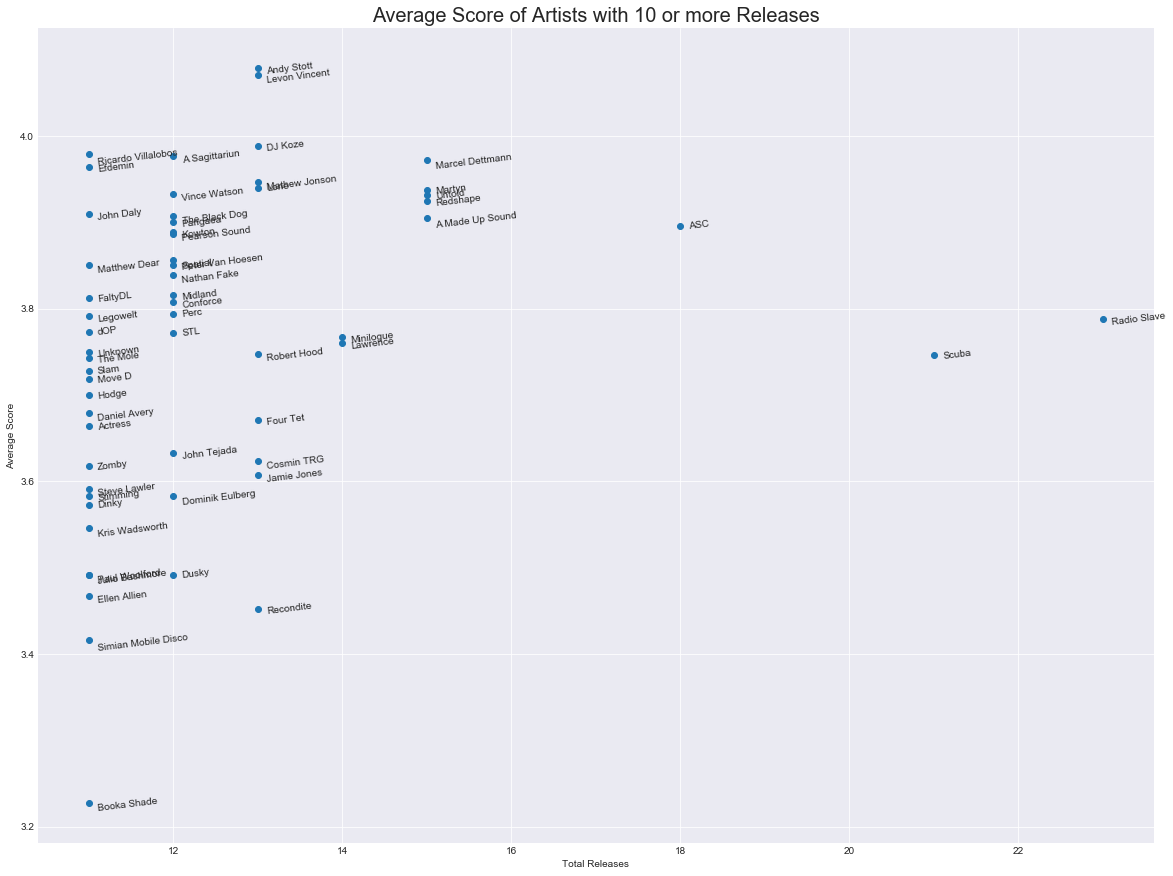

In [25]:
#the japanese version of the site creates a separate review entry for some releases. This line removes those
df_cleaned = df.sort_values(['artist','release_title','num_comments'],ascending=True).drop_duplicates(["artist",'release_title'],keep='last')

#group by artists and count how many reviews each artist has. Sort descending. Then lop off the first two, as those are Various Artists or unknown
artist_count = df_cleaned.groupby("artist").rating.count().sort_values(ascending=False).iloc[2:]

#one more "Unknown Artist" placeholder artist to drop
artist_count.drop('Unknown Artist',inplace=True)


#create list of artists with over 10 releases 
artists_over_ten_releases = list(artist_count[artist_count > 10].index)

#compile average ratings for those artists
artist_average = df[df['artist'].isin(artists_over_ten_releases)].groupby("artist").rating.mean()

#merge them into the same dataframe
artist_average = artist_average.to_frame().reset_index()
artist_count = artist_count.to_frame().reset_index()
top_artists_releases_ratings = pd.merge(artist_average,artist_count,how="inner",on="artist").set_index("artist")
top_artists_releases_ratings.columns = ['Avg Rating',"Releases"]

artists_list = list(top_artists_releases_ratings.index)


sns.set_style("darkgrid")
plt.figure(figsize=(20,15))
plt.scatter(top_artists_releases_ratings["Releases"],top_artists_releases_ratings["Avg Rating"])

for i,txt in enumerate(artists_list):
            plt.annotate(str(artists_list[i]).decode('utf-8'),
                     (top_artists_releases_ratings["Releases"].iloc[i] + 0.1,
                      top_artists_releases_ratings["Avg Rating"].iloc[i]),
                     rotation=7,size=10
                    )

plt.xlabel("Total Releases")
plt.ylabel("Average Score")
plt.title("Average Score of Artists with 10 or more Releases",size=20)
plt.show()


The graph above shows a sort of 'Long-term All-Stars' list in RA's eyes. It's safe to say that while an artist may have an "off" release here and there, the artists above are the most consistant at putting out releases that are well-received by the site's editorial staff for a large portion of their career.

It appears there are several ways an artist can make it on this graph and stand out: by either having a long string of above-average reviews, like Radio Slave on the right, or having a little less releases reviewed, but by those reviews having a very high average score, like Andy Stott at the top. ASC comes closest to doing both with 18 releases and an average score of about 3.9.

The next section takes a deeper dive into the careers of a few of these artists and more.

## Let's Compare Some Artist Stats

While a nice position in the graph above might give us a general sense that an artist has had a good run over their career, we can look a bit more closely at how an artist got there.

Using the function below, we can map individual releases from any number of artists on the same graph. By putting the year on the x-axis, the release score on the y-axis, and using bubble size to reflect the number comments on the review article as a mesure of popularity or the 'splash' made by the release, we can get a clear picture of an artist's history in RA reviews.

The function is written to be reusable, and has the option to show the release titles or not, as some artist have many releases and the labels will crowd the graph.

In [8]:
def ArtistRatingStats(artists_to_search,show_releases=True):
    
    #chop out relevant artists
    artist_results = df[df.artist.isin(artists_to_search)]
    
    #elimiate duplicates
    artist_results = artist_results.sort_values(['artist','release_title','num_comments'],ascending=True).drop_duplicates(["artist",'release_title'],keep='last')
        
    #create datetime array for release dates
    dates = pd.to_datetime(artist_results.release_month + " " +artist_results.release_year).values
    
    #create list of release artist and release title
    releases = (artist_results.release_title).values
    
    
    #get plotting data for each artist in list and plot
    for artist in artists_to_search:
        
        artist_rows = artist_results[artist_results.artist == artist]
        
        artist_dates = pd.to_datetime(artist_rows.release_month + " " +artist_rows.release_year).values
    
        plt.scatter(artist_dates,artist_rows.rating,s=(artist_rows.num_comments*10**2.6 + 300),alpha=.5)
    
    #create annotations
    if show_releases:
        for i,txt in enumerate(releases):
            plt.annotate(str(releases[i]).decode('utf-8'),
                     (dates[i] ,artist_results.rating.iloc[i] + 0.01),
                     rotation=7,size=10
                    )
    
    #format plot and add labels
    plt.xlabel("Year", size=30)
    plt.ylabel("Release Score",size=30)
    plt.xticks(rotation=60,size=30)
    plt.yticks(size=30)
    
    title = ""
    for artist in artists_to_search:
        title += artist + " Vs. "
    title = title[:-4]
    plt.legend(artists_to_search,markerscale=.2,
               frameon=True,
               fancybox=True,
               shadow=True,
               facecolor="w",
               labelspacing=1,
               fontsize=14)
    plt.title(title,size=40)
    plt.show()
    


Comparing two standout artists from the earlier graph, we can get a deeper picture into the career trajectory of these two artists through the lense of RA reviews.

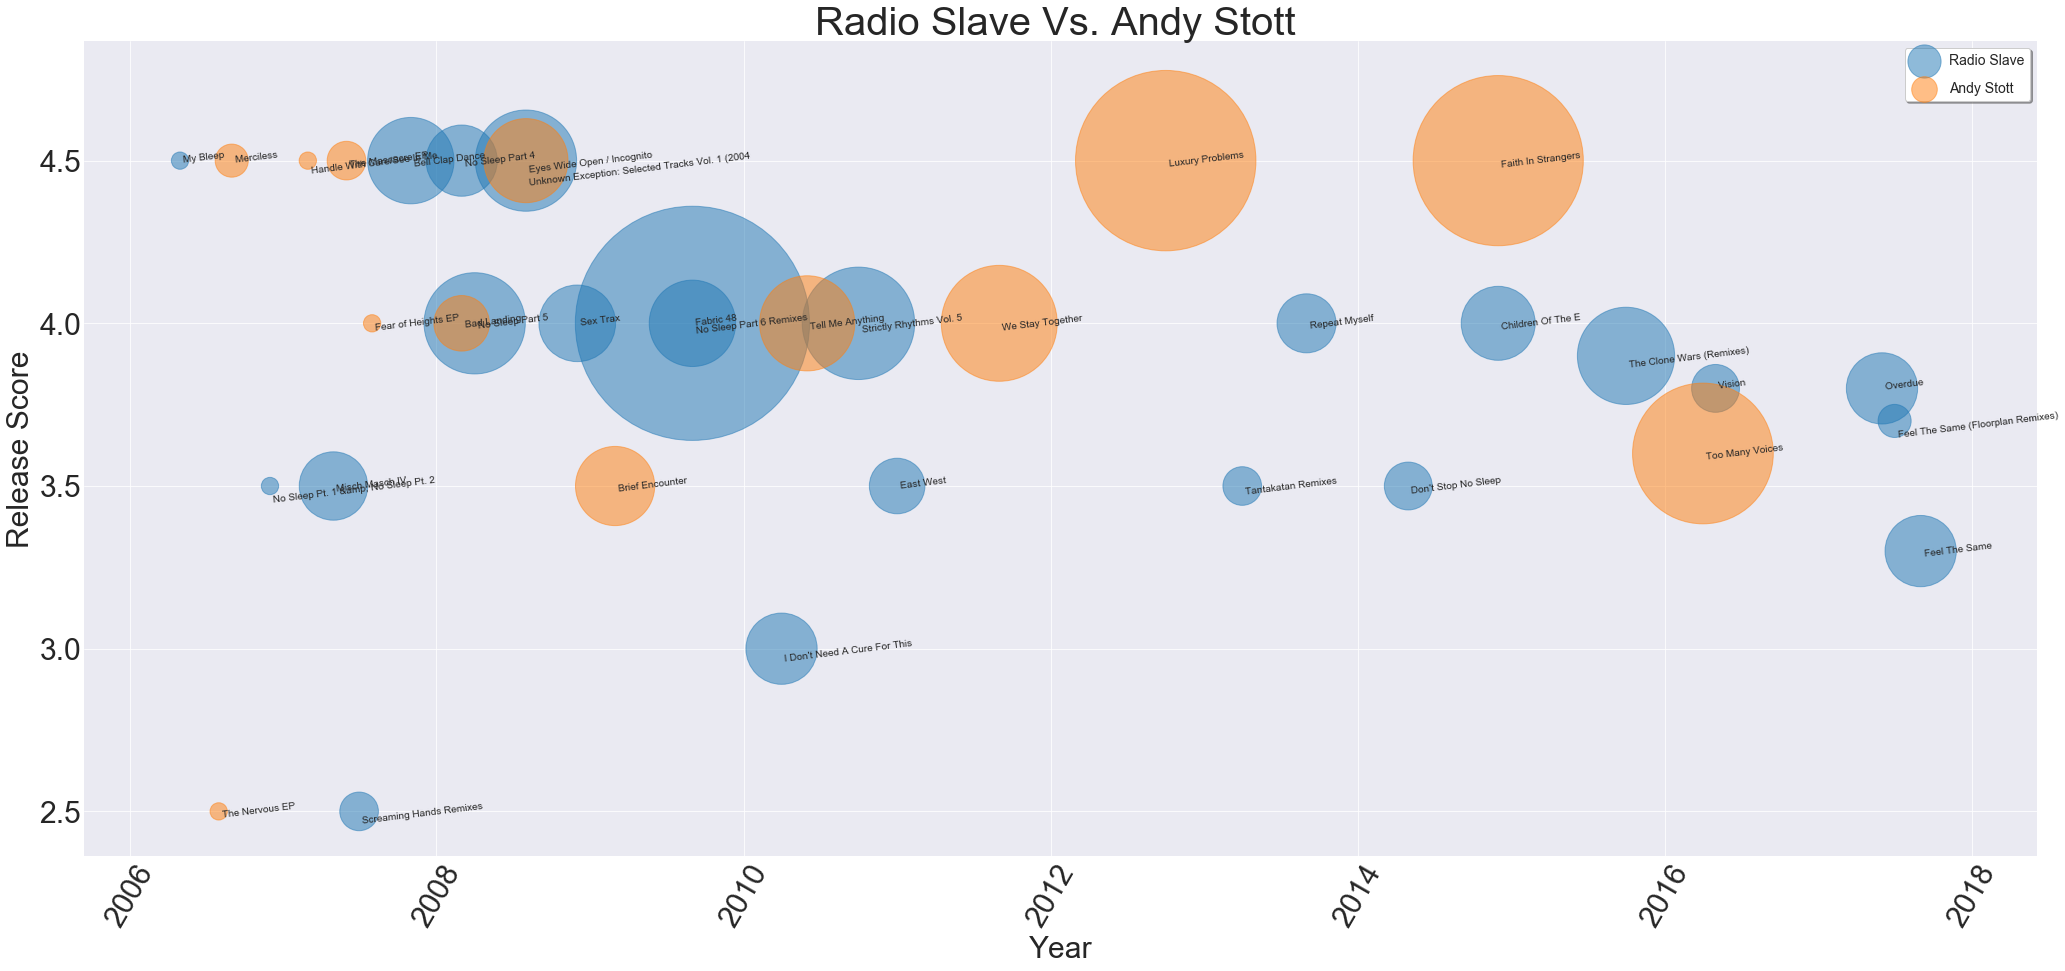

In [9]:
#figure controls
sns.set_style("darkgrid")
plt.figure(figsize=(35,15))

#function call
ArtistRatingStats(["Radio Slave","Andy Stott"],show_releases=True)

Interestingly, these two artist emerged in similar ways, and at close to the same time. Both artists first few releases came out of the gate very strongly, each with four 4.5 releases by 2009. Both had an early stumble, as well, with both Radio Slave and Andy Stott delivering relative flops during their otherwise critically-acclaimed debut set of releases.

From about 2009 to 2012, Radio Slave was a bit more prolific, several releases earned him some 4.0's, and a few came in just under that. Stott, had a few well reviewed releases in that time, just not as many.

In the more recent half of their careers so far is where the biggest difference occurs and it's this section of releases that most explain the different positions on the releases vs. average score chart above. From 2012 through 2017, Stott put out releases earning himself high scores from RA. His most recent, <i>Too Many Voices</i> is his first sub-four release since 2011. In that timeframe, Radio Slave has been more prolific, churning out nine releases, and while none were critical flops, none came in above four.


## Let's Compare Some Label Stats

In the same way artist's careers have journeys that can be mapped by their releases, the story of individual record labels can be told the same way. The rise and fall of these labels, small and large, are as essential to the fabric of the scene as any one artist.

Below, the same function above has been modified to accept a list of labels as input, and display the results in the same way.

In [10]:
def LabelRatingStats(labels_to_search,show_releases=True):
    
    #chop out relevant labels
    label_results = df[df.label.isin(labels_to_search)]
    
    #elimiate duplicates
    label_results = label_results.sort_values(['artist','release_title','num_comments'],ascending=True).drop_duplicates(["artist",'release_title'],keep='last')
         
    #create datetime array for release dates
    dates = pd.to_datetime(label_results.release_month + " " +label_results.release_year).values
    
    #create list of release artist and release title
    releases = (label_results.artist + " - " + label_results.release_title).values
    
    
    #get plotting data for each label in list and plot
    for label in labels_to_search:
        
        label_rows = label_results[label_results.label == label]
        
        label_dates = pd.to_datetime(label_rows.release_month + " " +label_rows.release_year).values
    
        plt.scatter(label_dates,label_rows.rating,s=(label_rows.num_comments*10**2.6 + 300),alpha=.5)
    
    #create annotations
    if show_releases:
        for i,txt in enumerate(releases):
            plt.annotate(str(releases[i]).decode('utf-8'),
                     (dates[i] ,label_results.rating.iloc[i] + 0.01),
                     rotation=7,size=10
                    )
    
    #format plot and add labels
    plt.xlabel("Year", size=30)
    plt.ylabel("Release Score",size=30)
    plt.xticks(rotation=60,size=30)
    plt.yticks(size=30)
    
    title = ""
    for label in labels_to_search:
        title += label + " Vs. "
    title = title[:-4]
    plt.legend(labels_to_search,markerscale=.2,
               frameon=True,
               fancybox=True,
               shadow=True,
               facecolor="w",
               labelspacing=1,
               fontsize=14)
    plt.title(title,size=40)
    plt.show()
    



Using the LabelRatingStats function. Let's take a look at some larger labels, closer to the indie side of underground dance music.

With larger budgets and rosters than most labels in our database, both Ghostly International and XL Recordings have a long history and many releases on Resident Advisor. For that reason, the chart will be crowded, and it makes sense to turn off the label names as to make it readable, and let the bubbles tell the story.

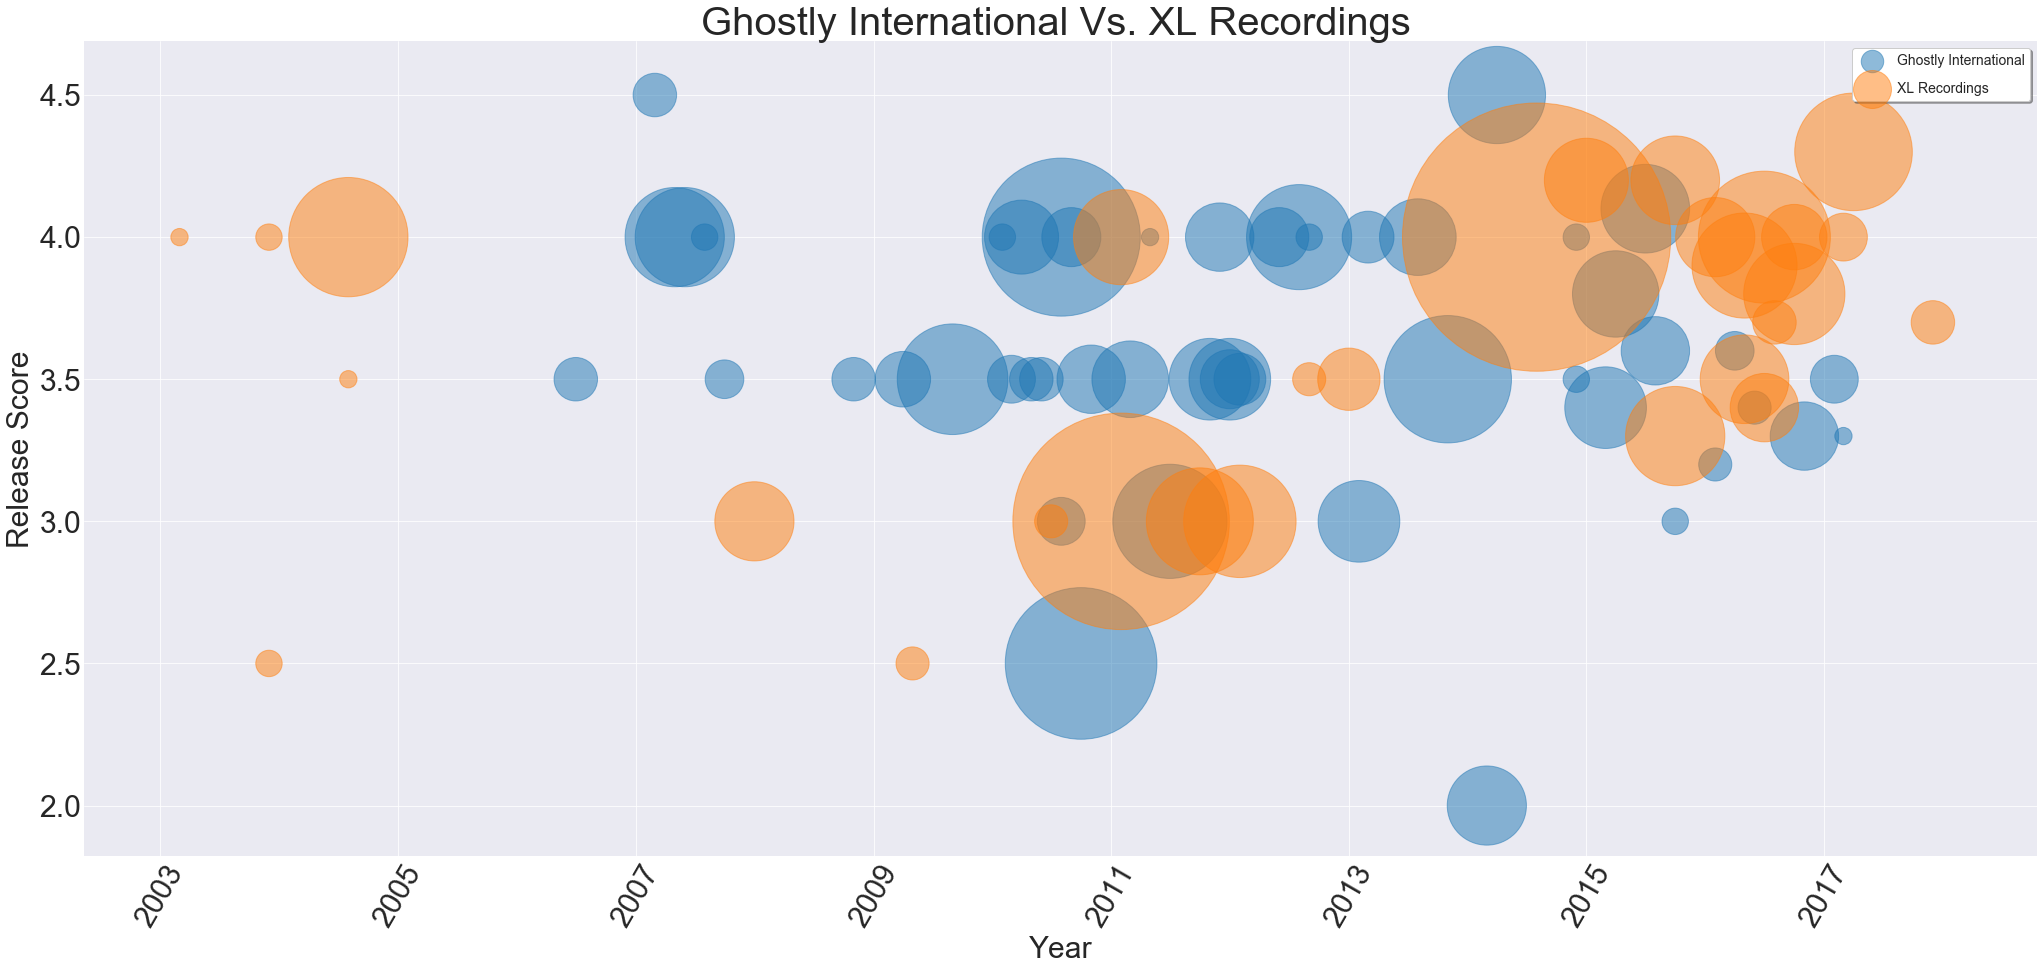

In [11]:
#figure controls

sns.set_style("darkgrid")
plt.figure(figsize=(35,15))


########
LabelRatingStats(['Ghostly International',"XL Recordings"],show_releases=False)



XL Recordings has been a part of dance music since before Resident Advisor has, which makes sense why they've got the earliest few bubbles on the chart above. XL gets a few solid releases in (and one flop) before Ghostly releaes start to show up on the site. They even have one release before 2005 with a relatively high amount of comments. This is especially harder to do in the earlier years of RA as readership has grown with the years. For the curious, that release is The Prodigy's <i>Always Outnumbered Never Outgunned</i>.

Since Ghostly appeared in late 2006, their history has mostly been a steady one. Most releases on RA fall into the 3.5 - 4.0 range (more on this below). Ghostly is, for the most part, no execption. They have a few releases above 4, and a small handfull more below. Ghostly also has the biggest flop on the chart. Scores of 2 are a rare sighting on RA. Turning labels, on, we can see that the dubious honor goes to Tycho's <i> Awake</i> LP.

In recent years, XL has been on a run. Since about early 2016, their release scores have hovered around 4.0 consistantly. In that time, Ghostly hasn't been as strong, with less reviewed releases, and lower scores for those releases compared to most of XL's in that timeframe.

Let's take a look at another three-way comparison to tell the simultanious stories of three smaller labels, each with a different focus in genre. The Bunker New York and Let's Play House are both labels from New York, with the Bunker releases being their signature brand of raw, warehouse techno, and Let's Play House a disco and house focused label. Adding to those two is Whities, a buzz-generating experimental techno label.

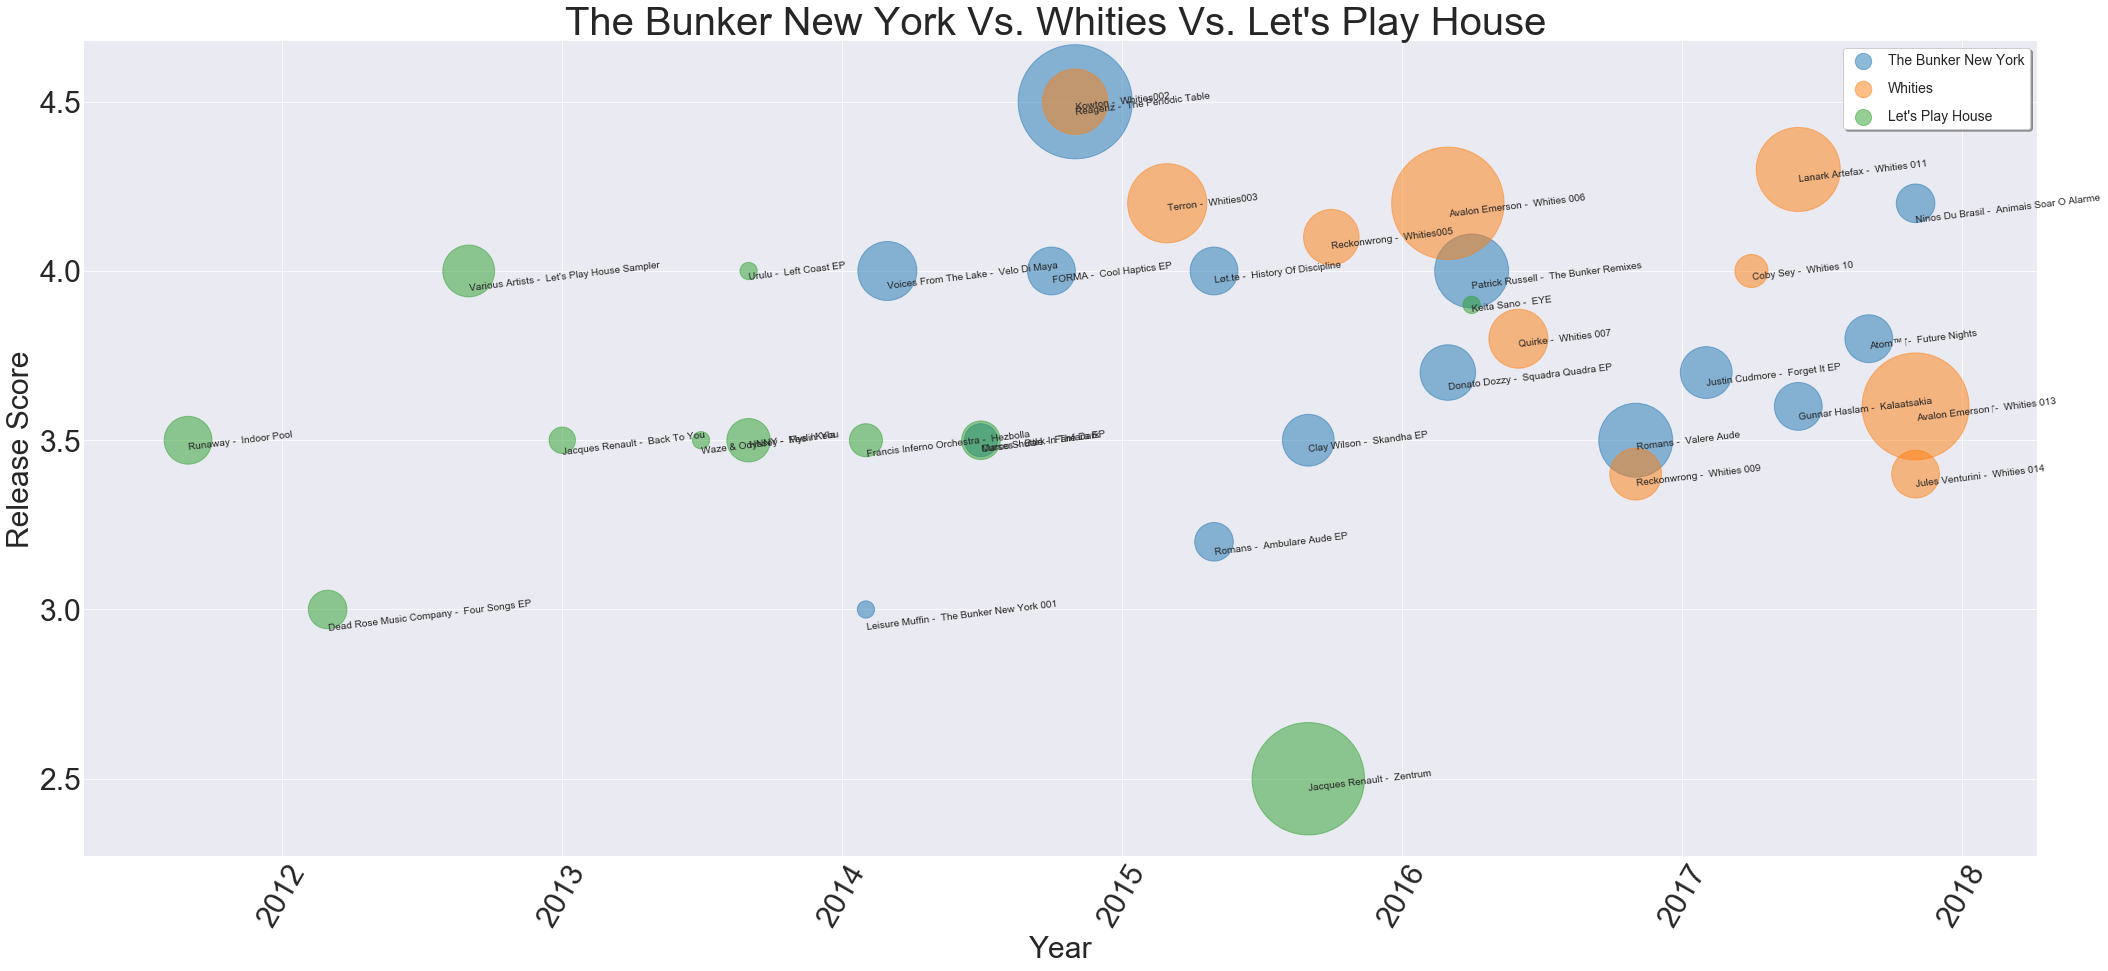

In [31]:
#figure controls
sns.set_style("darkgrid")
plt.figure(figsize=(35,15))

#function call
LabelRatingStats(["The Bunker New York","Whities","Let's Play House"],show_releases=True)

As these are different subgenres it's probably best to consider these independent to each other, but by plotting them together, we can see how different labels can occupy a similar time in the underground electronic music scene.

Below, we will take a dive into looking at how sub-genres can fill in a picture of the recent history of underground dance music.

## Diving Into Subgenres

A favorite pastime of any real music nerd is talking the head off of anyone that will listen about the intricacies of specific subgenres of the main genre they're interested in. Underground dance is certainly no different. Through the years, like labels and artists, subgenres rise, fall, and occasionally reemerge as trends come and go.

Below, two functions help tell that story using data from Resident Advisor.

First, some cleaning. As gathered from the site by the scraper, the "styles" attribute of a release will be a comma-separated list of generes. (e.x. "House, Techno, Experimental"). Thus, when searching for a techno release, it makes the most sense to search to see if that genre appears in the list of styles at all. Thus, it's possible for a release to appear in both a search for "House" and a search for "Techno". This is by design. Using this strategy, there is one search issue to address. "Electro" and "Electronica" are separate, distinct genres. Very literally, the word "Electronica" contains the word "Electro", for this reason, in order to preserve the ability to easily search for either, we will use a dataframe that has been modified to adjust the word "Electronic" to use a lower-case "e". This way, a search for "Electro" and a search for "electronica" will give separate results.

In [13]:
df_styles = df[df['style'].notnull()].copy()

lower_case_electronic = df_styles['style'].replace("Electronic",'electronic')
df_styles['style'] = lower_case_electronic


Now, the function. There are a few ways to quantify the significance of a genre according to Resident Advisor. This first function takes a look at the average score of releases of any genre in a list, year-over-year. The premise being that a dominant genre will be the one on the highest review scores.

In [14]:
def GenreRatingCompare(genres):
    
    #initialize lists and dataframe
    genre_rating_dataframes = []
    combine_ratings = pd.DataFrame()

    #create lists of average ratings per year on df rows that contain style in i element of list
    for i in range(0,len(genres)):
        genre_rating_dataframes.append(df_styles[df_styles['style'].str.contains(genres[i])].groupby('release_year').rating.mean())

    #add these rows back into a single dataframe
    for i in range(0,len(genres)):
        combine_ratings = pd.concat([combine_ratings,genre_rating_dataframes[i]],axis=1)

    #columns in the new dataframe will match the passed in list of genres
    combine_ratings.columns = genres

    #format the figure
    plt.figure(figsize=(20,10))
    sns.set_style("darkgrid")
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.ylabel("Average score of release containng genre",fontsize=20)
    plt.title("Average Score of Sub-Genre per Year",fontsize=25)

    #plot combined dataframe
    _ = plt.plot(combine_ratings.dropna())

    #format legend
    plt.legend(genres,prop={'size': 15})
    

For this comparison, let's take a look at a standard set of genres.

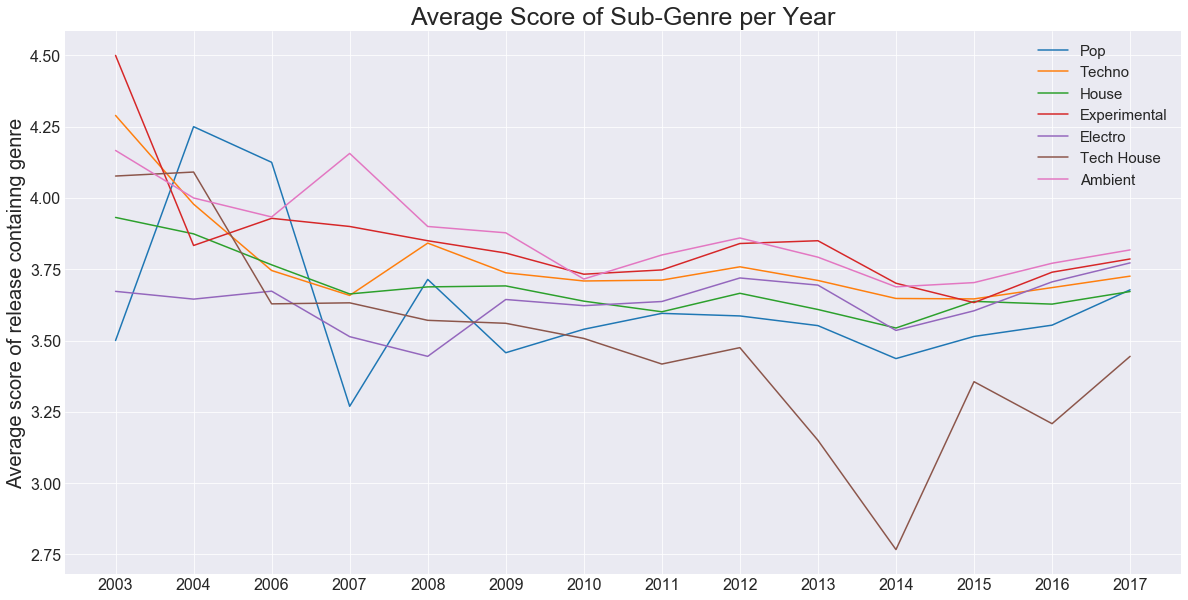

In [37]:
GenreRatingCompare(["Pop","Techno","House",'Experimental','Electro',"Tech House","Ambient"])

This graph shows a relatively high amount of variance in the early years of RA reviews, but, with major genres, as the year gets closer to 2017, the amount of variance between the two genres goes down by quite a bit. The exception is Tech House, a sub-genre that's fallen out of favor with the underground set in the last decade or so. The fall of Tech House is more visible in this chart than any other trend.

As a general trend, reviews on RA have trended more and more to the 3.7 range. Before 2015, reviews were on a scale of .5, with most reviews being either 3.5 or 4.0. Since 2015, the average score has hovered around 3.7. We can see the shrinking of the standard deviation of all review scores in the below graph.

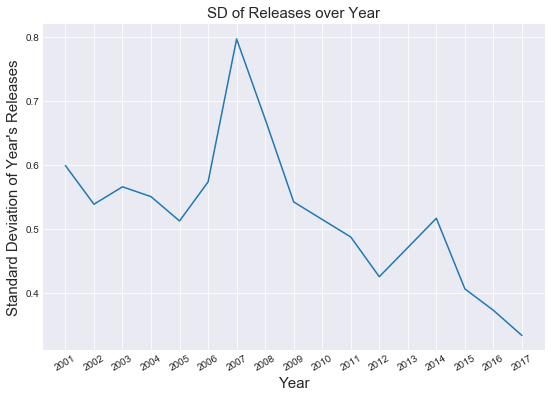

In [16]:
#simple group by year and aggrigate with standard deviation of the rating
std = df.groupby('release_year').rating.std()

#format and show graph
plt.figure(figsize=(9,6))
plt.xlabel("Year",fontsize=15)
plt.xticks(rotation=30)
plt.ylabel("Standard Deviation of Year's Releases",fontsize=15)
plt.title("SD of Releases over Year",fontsize=15)
_ = plt.plot(std)

Since the site began, the standard deviation of the releases has been roughly reduced by half.

Given this, there is a better way to track the popularity or relevance of a genre according to the website. If we assume that Resident Advisor chooses records that are relevant to the scene at the current moment (as you'd expect for any review site), then the total count of records with a certain genre is an indicator of that genre's relevance to the scene in that timeframe. 

As the amount of reviews per year has changed, it makes sense to view the appearance frequency of a genre with respect to the total amount of reviews in that time period.

The below function does just that.

In [17]:
def GenrePrecentCompare(genres):

  #initialize lists and dataframes
  genre_count_dataframes = []
  columns = []
  percents = pd.DataFrame()
  combine_counts = pd.DataFrame()

  #loop through provided styles, chop out release *containing* that style, group by year and count
  for i in range(0,len(genres)):
      genre_count_dataframes.append(df_styles[df_styles['style'].str.contains(genres[i])].groupby('release_year').release_type.count())

  #also track how many releases total per year
  all_count_by_year = df_styles.groupby("release_year").release_type.count()


  #create single dataframe from genre count series'
  for i in range(0,len(genres)):
      combine_counts = pd.concat([combine_counts,genre_count_dataframes[i]],axis=1)
      
      #also add entry to list for column names
      columns.append(genres[i])

  #add the all-releases column to dataframe
  combine_counts = pd.concat([combine_counts,all_count_by_year],axis=1)

  #add "all" column label to list of labels
  columns.append("all")

  #set dataframe labels to list of labels
  combine_counts.columns = columns

  #populate new dataframe -percents- with percentage values of releases containing genres from combine_counts dataframe
  for i in range(0,len(genres)):
      percents[genres[i]] = combine_counts[genres[i]] / combine_counts['all'] * 100

  #if no releases with that genre existed that year, replace with 0
  percents = percents.fillna(0)

  #format figure
  plt.figure(figsize=(20,10))
  sns.set_style("darkgrid")

  plt.legend(genres,
                 frameon=True,
                 fancybox=True,
                 shadow=True,
                 facecolor="w",
                 labelspacing=1,
                 fontsize=14)
  plt.tick_params(axis='both', which='major', labelsize=16)
  plt.ylabel("% Of Releases Containing Genre",fontsize=20)

  #plot dataframe
  _ = plt.plot(percents)

  #format legend
  plt.legend(genres,prop={'size': 15})

  plt.show()



Let's take a look at the same set of genres as above.

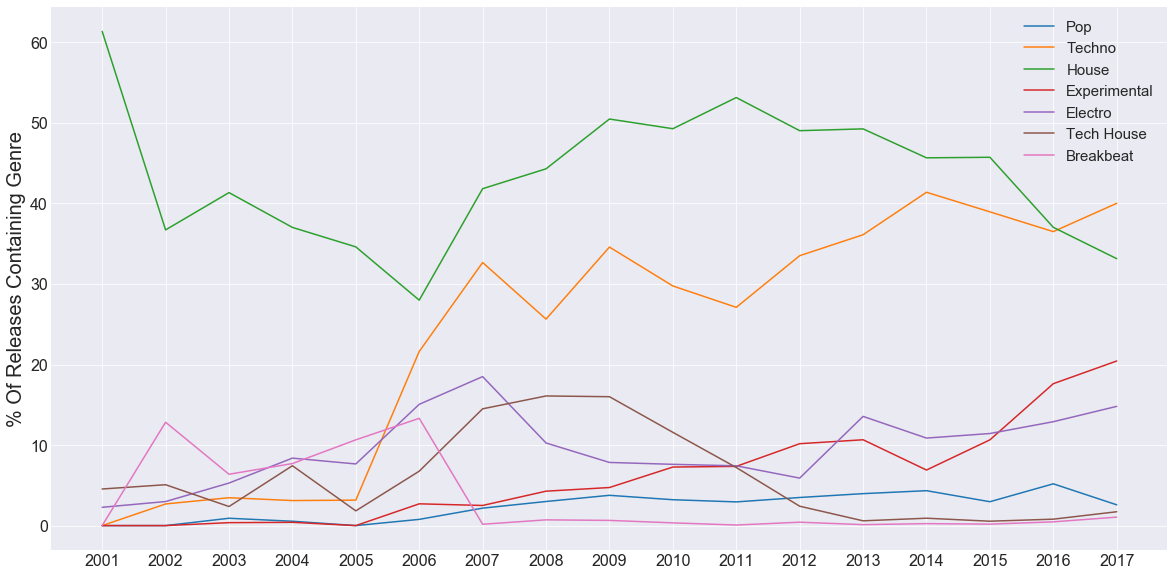

In [38]:
GenrePrecentCompare(["Pop","Techno","House",'Experimental','Electro',"Tech House","Breakbeat"])

This chart tells a better story.

From the start of the site until 2006, House music was king. During 2005, RA made a big effort to start reviewing more Techno releases, but it took until 2017 for Techno to become the more dominant genre on the site.

It's also easier to see genre trends in this graph. As with the previous graph you can tell that Tech House had a real fall-from-grace in popularity in the early 2010's. You can also see a trend with Electro that isn't visable on the release scores chart. Electro had it's biggest peak on RA so far in 2007, though it's average release score for that year doesn't show this. Since a dip in the early 2010's, Electro has started to come back in percentage. This reflects the site's  __[year-end editorial](https://www.residentadvisor.net/features/3090)__.

Using this function, it's possible to map the rise and fall in popularlity of 16+ years of subgenres to get a picture of shifting trends over the years.

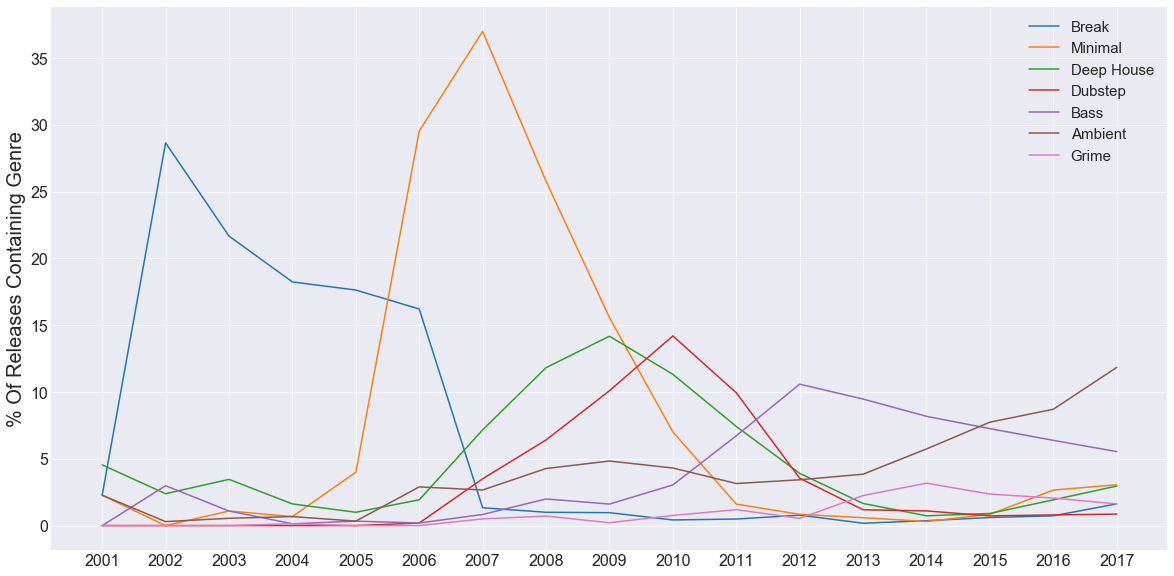

In [36]:
GenrePrecentCompare(["Break",'Minimal',"Deep House","Dubstep","Bass","Ambient","Grime"])

Or, we can graph even smaller sub-genres on their own to see their shape of popularity through the lens of Resident Advisor.

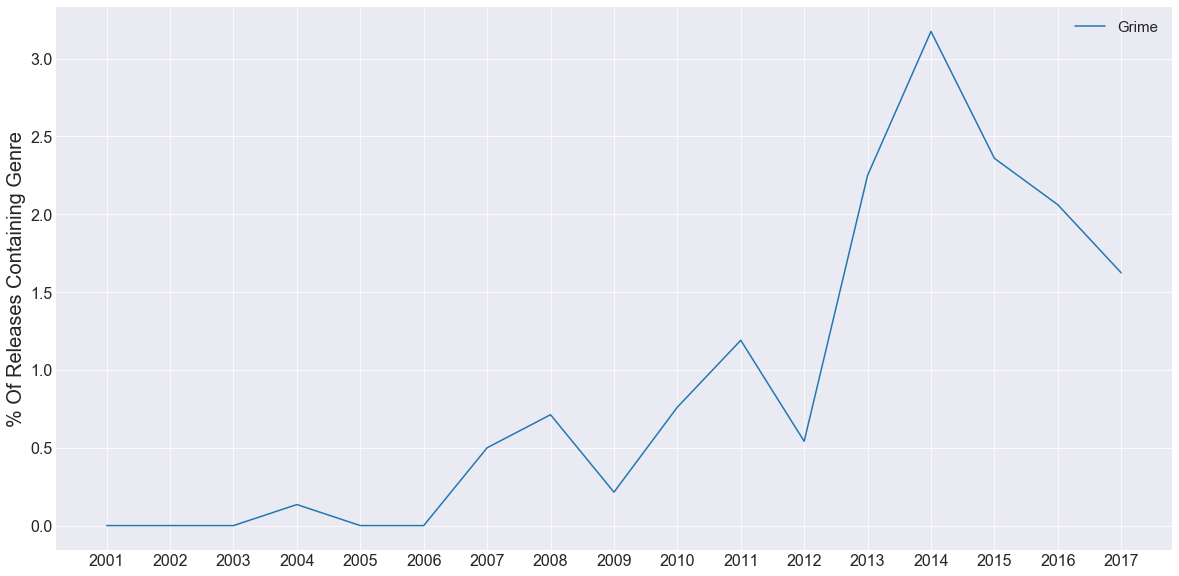

In [20]:
GenrePrecentCompare(["Grime"])

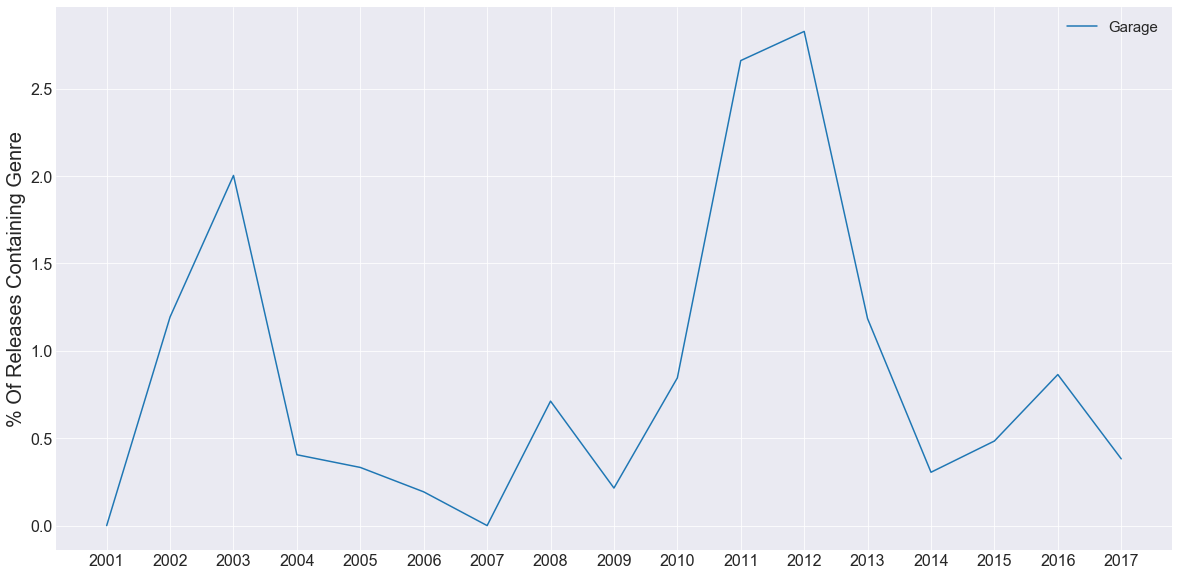

In [21]:
GenrePrecentCompare(["Garage"])

## Conclusion and a Note

The analysis above is only a scratch on the surface of the stories that can emerge from this dataset. So many more stories from the underground dance music scene can be uncovered using similar methods. However it's important to remember that Resident Advisor is a site with a unique and subjective editorial voice. While it appears that they try their best to represent the scene as a whole, the site itself has tastes and judgements, that are perhaps lost in charts derived from their data alone. That should be kept in mind when reading the charts above.